<a href="https://colab.research.google.com/github/georgievw/RTProject/blob/master/TitanicProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ДЗ4-6 Арсентьев ИУ6-51Б

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
)

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    accuracy_score,
    roc_auc_score,
    recall_score,
    roc_curve,
    f1_score,  
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)

Загрузим тренировочный датасет из Kaggle

In [ ]:
train = pd.read_csv('train.csv')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Попробуем выявить зависимости между фичами и вероятностью выжить


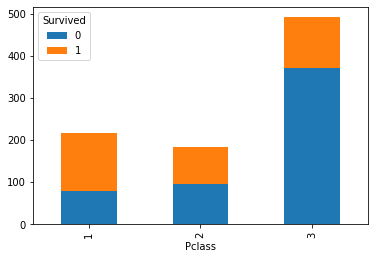

In [ ]:
train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)

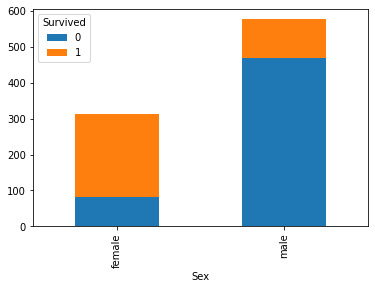

In [ ]:
train.pivot_table('PassengerId', 'Sex', 'Survived', 'count').plot(kind='bar', stacked=True)

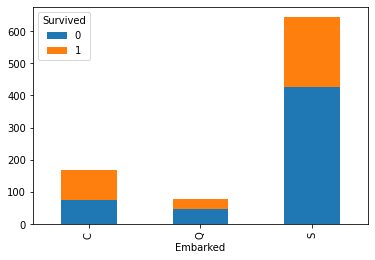

In [ ]:
train.pivot_table('PassengerId', 'Embarked', 'Survived', 'count').plot(kind='bar', stacked=True)

Зависимость выживаемости от пола и от класса обслуживания выглядит логичной, в то время, как зависимость от пункта отправления вызывает вопросы

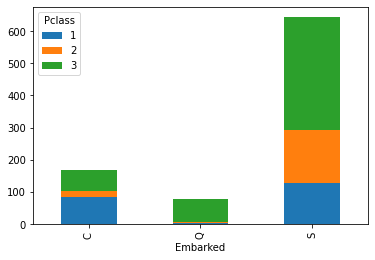

In [ ]:
train.pivot_table('PassengerId', 'Embarked', 'Pclass', 'count').plot(kind='bar', stacked=True)

Из полученной гистограммы можно сделать вывод, что пункт отправления сильно связан с классом обслуживания. Тем не менее оставим эту фичу в учебных целях

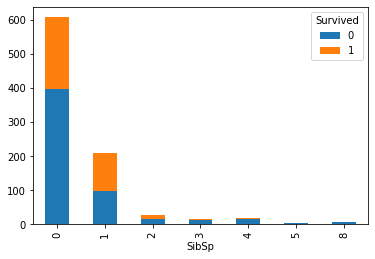

In [ ]:
train.pivot_table('PassengerId', 'SibSp', 'Survived', 'count').plot(kind='bar', stacked=True)

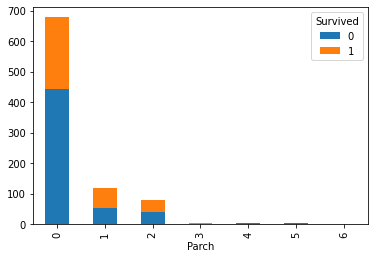

In [ ]:
train.pivot_table('PassengerId', 'Parch', 'Survived', 'count').plot(kind='bar', stacked=True)

Основываясь на похожем распределении выживших/погибших по количеству двух видов родственников на борту, объединим эти фичи в одну

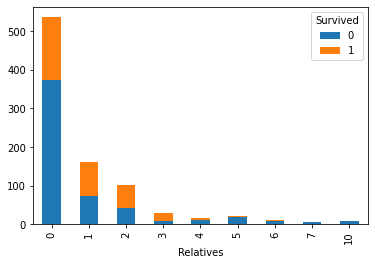

In [ ]:
train['Relatives'] = train.SibSp + train.Parch
train = train.drop(['SibSp', 'Parch'], axis=1)
train.pivot_table('PassengerId', 'Relatives', 'Survived', 'count').plot(kind='bar', stacked=True)


Удалим из данных неинформативные/трудные для анализа столбцы. (При дальнейшем совершествовании модели можно получать информацию о социальном положении и возрасте человека по его имени, информацию о расположении кают по номеру билета и номеру каюты)

In [ ]:
train = train.drop(['Name', 'Cabin', 'Ticket','PassengerId'], axis=1)
train

,Survived,Pclass,Sex,Age,Fare,Embarked,Relatives
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0
...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,0
887,1,1,female,19.0,30.0000,S,0
888,0,3,female,NaN,23.4500,S,3
889,1,1,male,26.0,30.0000,C,0


Заполним пропущены поля с возрастом средними значениями

In [ ]:
train['Age'] = train['Age'].fillna(train['Age'].mean())
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Sex        891 non-null    object 
 3   Age        891 non-null    float64
 4   Fare       891 non-null    float64
 5   Embarked   889 non-null    object 
 6   Relatives  891 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


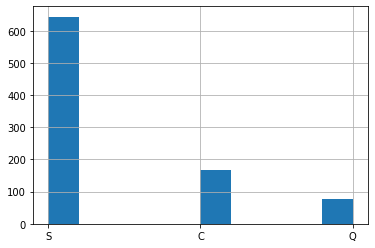

In [ ]:
train['Embarked'].hist()

Заполним два пустых поля с пунктом отправления самыми часто встречающимися значениями (S)

In [ ]:
train['Embarked'] = train['Embarked'].fillna('S')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Sex        891 non-null    object 
 3   Age        891 non-null    float64
 4   Fare       891 non-null    float64
 5   Embarked   891 non-null    object 
 6   Relatives  891 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


Преобразуем столбец 'Embarked' с категориальными значениями при помощью OneHotEncoding (т.к. более двух классов, которые невозможно упорядочить)

In [ ]:
train = pd.get_dummies(train, columns=['Embarked'])
train

,Survived,Pclass,Sex,Age,Fare,Relatives,Embarked_C,Embarked_Q,Embarked_S
0,0,3,male,22.000000,7.2500,1,0,0,1
1,1,1,female,38.000000,71.2833,1,1,0,0
2,1,3,female,26.000000,7.9250,0,0,0,1
3,1,1,female,35.000000,53.1000,1,0,0,1
4,0,3,male,35.000000,8.0500,0,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,13.0000,0,0,0,1
887,1,1,female,19.000000,30.0000,0,0,0,1
888,0,3,female,29.699118,23.4500,3,0,0,1
889,1,1,male,26.000000,30.0000,0,1,0,0


Значения столбца, содержащего пол, закодируем нулями и единицами

In [ ]:
train['Sex'] = train['Sex'].map({'female': 0, 'male': 1})
train

,Survived,Pclass,Sex,Age,Fare,Relatives,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.000000,7.2500,1,0,0,1
1,1,1,0,38.000000,71.2833,1,1,0,0
2,1,3,0,26.000000,7.9250,0,0,0,1
3,1,1,0,35.000000,53.1000,1,0,0,1
4,0,3,1,35.000000,8.0500,0,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,13.0000,0,0,0,1
887,1,1,0,19.000000,30.0000,0,0,0,1
888,0,3,0,29.699118,23.4500,3,0,0,1
889,1,1,1,26.000000,30.0000,0,1,0,0


Отделим от данных целевые значения

In [ ]:
y = train['Survived']
X = train.drop(['Survived'], axis=1)
X

,Pclass,Sex,Age,Fare,Relatives,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.000000,7.2500,1,0,0,1
1,1,0,38.000000,71.2833,1,1,0,0
2,3,0,26.000000,7.9250,0,0,0,1
3,1,0,35.000000,53.1000,1,0,0,1
4,3,1,35.000000,8.0500,0,0,0,1
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,13.0000,0,0,0,1
887,1,0,19.000000,30.0000,0,0,0,1
888,3,0,29.699118,23.4500,3,0,0,1
889,1,1,26.000000,30.0000,0,1,0,0


Проведем ту же самую обработку для тестовых данных, взятых с Kaggle

In [ ]:
test = pd.read_csv('test.csv')
ids = test['PassengerId']
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())
test['Relatives'] = test['SibSp'] + test['Parch']
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1)
test['Sex'] = test['Sex'].map({'female': 0, 'male': 1})
test = pd.get_dummies(test, columns=['Embarked'])
test

,Pclass,Sex,Age,Fare,Relatives,Embarked_C,Embarked_Q,Embarked_S
0,3,1,34.50000,7.8292,0,0,1,0
1,3,0,47.00000,7.0000,1,0,0,1
2,2,1,62.00000,9.6875,0,0,1,0
3,3,1,27.00000,8.6625,0,0,0,1
4,3,0,22.00000,12.2875,2,0,0,1
...,...,...,...,...,...,...,...,...
413,3,1,30.27259,8.0500,0,0,0,1
414,1,0,39.00000,108.9000,0,1,0,0
415,3,1,38.50000,7.2500,0,0,0,1
416,3,1,30.27259,8.0500,0,0,0,1


Соединим тренировочные и тестовые данные для тренировки стандартизатора, и стандартизируем тренировочные данные

In [ ]:
scaler = StandardScaler()    
scaler.fit(X.append(test))
X = pd.DataFrame(scaler.transform(X), columns=['Pclass',	'Sex',	'Age',	'Fare',	'Relatives',	'Embarked_C',	'Embarked_Q',	'Embarked_S'])
X

,Pclass,Sex,Age,Fare,Relatives,Embarked_C,Embarked_Q,Embarked_S
0,0.841916,0.743497,-0.612031,-0.503629,0.073352,-0.50977,-0.322040,0.655011
1,-1.546098,-1.344995,0.630318,0.734468,0.073352,1.96167,-0.322040,-1.526692
2,0.841916,-1.344995,-0.301444,-0.490578,-0.558346,-0.50977,-0.322040,0.655011
3,-1.546098,-1.344995,0.397377,0.382890,0.073352,-0.50977,-0.322040,0.655011
4,0.841916,0.743497,0.397377,-0.488161,-0.558346,-0.50977,-0.322040,0.655011
...,...,...,...,...,...,...,...,...
886,-0.352091,0.743497,-0.223797,-0.392452,-0.558346,-0.50977,-0.322040,0.655011
887,-1.546098,-1.344995,-0.844971,-0.063753,-0.558346,-0.50977,-0.322040,0.655011
888,0.841916,-1.344995,-0.014219,-0.190399,1.336749,-0.50977,-0.322040,0.655011
889,-1.546098,0.743497,-0.301444,-0.063753,-0.558346,1.96167,-0.322040,-1.526692


Разделим имеющиеся размеченные данные на тренировочные и тестовые

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=10)

Натренируем простую линейную регрессию, используя для оценки кросс-валидацию

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=4)
print(scores)
print(scores.mean())
print(scores.std())

[0.80898876 0.80337079 0.76404494 0.81460674]
0.797752808988764
0.019862550033329988


Выведем разные оценки модели

In [ ]:
print('accuracy = %f' %accuracy_score(y_test, clf.predict(X_test)))
print('precision = %f' %precision_score(y_test, clf.predict(X_test), pos_label=1))
print('recall = %f' %recall_score(y_test, clf.predict(X_test), pos_label=1))
print('f1 = %f' %f1_score(y_test, clf.predict(X_test), pos_label=1))

accuracy = 0.888268
precision = 0.862069
recall = 0.806452
f1 = 0.833333


Высчитаем AUC-ROC

In [ ]:
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
print('AUC-ROC = %f' %lr_auc)

AUC-ROC = 0.923178


In [ ]:
#небольший тест для себя
a, = np.where((tpr-fpr) == (tpr-fpr).max())
new_predict = lr_probs.copy()
b = np.ones(new_predict.shape)
size, = b.shape
size
for i in range(size):
  if new_predict[i] < treshold[a[0]]:
    new_predict[i] = 0
  else:
    new_predict[i] = 1

print(accuracy_score(y_test, new_predict))
print(precision_score(y_test, new_predict, pos_label=1))
print(recall_score(y_test, new_predict, pos_label=1))

0.87
0.8421052631578947
0.8791208791208791


Построим ROC-кривую

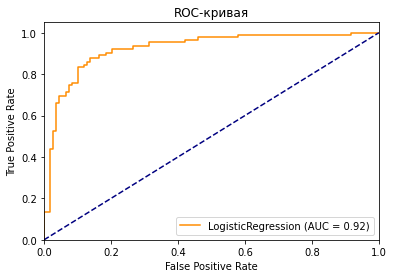

In [ ]:
plt.plot(fpr, tpr, color='darkorange', label='LogisticRegression (AUC = %0.2f)' % lr_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Выведем матрицу ошибок

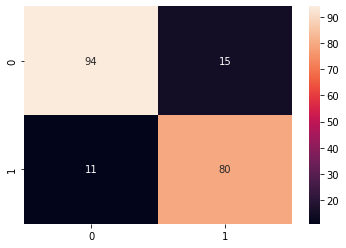

In [ ]:
clf_matrix = confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(clf_matrix, annot=True)

Попробуем еще несколько классификаторов, подбирая параметры

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8581460674157303
0.8435754189944135


In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9859550561797753
0.7821229050279329


In [ ]:
clf = RandomForestClassifier(max_depth=8, n_estimators=140)
clf.fit(X, y)
#clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=4)
print(scores.mean())
print(scores.std())

0.7991573033707865
0.03137402795461892


In [ ]:
print('accuracy = %f' %accuracy_score(y_test, clf.predict(X_test)))
print('precision = %f' %precision_score(y_test, clf.predict(X_test), pos_label=1))
print('recall = %f' %recall_score(y_test, clf.predict(X_test), pos_label=1))
print('f1 = %f' %f1_score(y_test, clf.predict(X_test), pos_label=1))

accuracy = 0.938547
precision = 0.947368
recall = 0.870968
f1 = 0.907563


In [ ]:
clf = GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=100)
clf.fit(X, y)
#clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8890449438202247
0.9329608938547486


In [ ]:
print('accuracy = %f' %accuracy_score(y_test, clf.predict(X_test)))
print('precision = %f' %precision_score(y_test, clf.predict(X_test), pos_label=1))
print('recall = %f' %recall_score(y_test, clf.predict(X_test), pos_label=1))
print('f1 = %f' %f1_score(y_test, clf.predict(X_test), pos_label=1))

accuracy = 0.932961
precision = 0.931034
recall = 0.870968
f1 = 0.900000


In [ ]:
clf = LinearSVC()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7991573033707865
0.8100558659217877


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Нормализируем тестовые данные, сделаем предсказания на основе выбранной модели

In [ ]:
test = pd.DataFrame(scaler.transform(test), columns=['Pclass',	'Sex',	'Age',	'Fare',	'Relatives',	'Embarked_C',	'Embarked_Q',	'Embarked_S'])
test

,Pclass,Sex,Age,Fare,Relatives,Embarked_C,Embarked_Q,Embarked_S
0,0.841916,0.743497,0.358554,-0.492430,-0.558346,-0.50977,3.105202,-1.526692
1,0.841916,-1.344995,1.329138,-0.508463,0.073352,-0.50977,-0.322040,0.655011
2,-0.352091,0.743497,2.493840,-0.456499,-0.558346,-0.50977,3.105202,-1.526692
3,0.841916,0.743497,-0.223797,-0.476318,-0.558346,-0.50977,-0.322040,0.655011
4,0.841916,-1.344995,-0.612031,-0.406228,0.705051,-0.50977,-0.322040,0.655011
...,...,...,...,...,...,...,...,...
413,0.841916,0.743497,0.030309,-0.488161,-0.558346,-0.50977,-0.322040,0.655011
414,-1.546098,-1.344995,0.707964,1.461794,-0.558346,1.96167,-0.322040,-1.526692
415,0.841916,0.743497,0.669141,-0.503629,-0.558346,-0.50977,-0.322040,0.655011
416,0.841916,0.743497,0.030309,-0.488161,-0.558346,-0.50977,-0.322040,0.655011


In [ ]:
submission = clf.predict(test)
submission = pd.DataFrame(submission, index=ids, columns=['Survived'])
submission.to_csv('submission12.csv')

Лучше всех себя показал градиентный бустинг с результатом score = 0.78708 и 1682 местом, что лишь немногим лучше, чем простое предсказание на основе пола (мужчина->0, женщина->1)